# Backtesting de Estrategia en XAUUSD

Este notebook prepara y ejecuta el backtesting de una estrategia de trading basada en indicadores técnicos sobre datos históricos de XAUUSD en velas de 1 minuto. El proceso incluye la preparación de datos, el desarrollo de la lógica de la estrategia, y el análisis de los resultados.

Este análisis permite obtener una visión completa de la rentabilidad y los riesgos de la estrategia antes de su posible optimización con Machine Learning.

---

## 1. Carga y Preparación de Datos

- ### Descarga de Datos
  Para obtener datos de alta calidad, descargué un total de 63 archivos CSV desde TradingView, con información de gráficos de 1 minuto para el par XAUUSD, abarcando el período del **4 de enero de 2021** al **25 de septiembre de 2024**.

- ### División del Conjunto de Datos
  Dividí los datos en dos subconjuntos para asegurar una evaluación equilibrada:

  - **Entrenamiento y Validación**: Datos desde el **4 de enero de 2021** hasta el **26 de abril de 2024**.
  - **Prueba**: Datos más recientes, desde el **29 de abril hasta el 25 de septiembre de 2024**.

- ### Límite de Horas de Operación
  Para centrarme en los periodos de mayor actividad y volatilidad, decidí limitar las horas de operación, mejorando así la precisión y relevancia de los resultados del backtest.

- ### Cálculo de Indicadores Técnicos
  Calculo una serie de indicadores técnicos necesarios para mi estrategia, asegurando que cada dato relevante esté disponible para el análisis.

- ### Verificación y Limpieza de Datos
  Realizo una limpieza exhaustiva de los datos, eliminando periodos con anomalías significativas, especialmente aquellos asociados a eventos de alto impacto (como noticias económicas) que podrían distorsionar el análisis del backtest.
isis del backtest.


In [3]:
import os
import pandas as pd
import pandas_ta as ta

# Función principal para cargar, filtrar, calcular indicadores y limpiar periodos
def preparar_datos(folder_path, start_date, end_date, periodos_a_eliminar):
    # Cargar todos los archivos CSV y concatenarlos en un DataFrame
    df_concatenado = pd.concat(
        [pd.read_csv(os.path.join(folder_path, f))
         for f in sorted(os.listdir(folder_path)) if f.endswith('.csv')],
        ignore_index=True
    )

    # Convertir la columna 'time' a formato datetime y ordenar
    df_concatenado['time'] = pd.to_datetime(df_concatenado['time'], unit='s')
    df_concatenado = df_concatenado.sort_values(by='time').reset_index(drop=True)

    # Filtrar por rango de fechas
    df_filtrado = df_concatenado[(df_concatenado['time'] >= start_date) & (df_concatenado['time'] <= end_date)]

    # Filtrar por horas de sesión en UTC (Londres y Nueva York)
    df_filtrado = df_filtrado.copy()  #
    df_filtrado['hour'] = df_filtrado['time'].dt.hour 
    mask_london = (df_filtrado['hour'] >= 5) & (df_filtrado['hour'] < 10)
    mask_newyork = (df_filtrado['hour'] >= 10) & (df_filtrado['hour'] < 16)
    df_filtrado = df_filtrado[mask_london | mask_newyork].drop(columns=['hour']).drop_duplicates(subset='time')

    # Calcular indicadores técnicos
    df_filtrado['ohlc_avg'] = (df_filtrado['open'] + df_filtrado['high'] + df_filtrado['low'] + df_filtrado['close']) / 4
    df_filtrado['EMA70'] = ta.ema(df_filtrado['ohlc_avg'], length=70)
    df_filtrado['EMA250'] = ta.ema(df_filtrado['ohlc_avg'], length=250)
    df_filtrado['RSI8'] = ta.rsi(df_filtrado['ohlc_avg'], length=8)

    # Eliminar filas nulas (primeros 250 valores debido a EMA250)
    df_filtrado = df_filtrado.iloc[250:].reset_index(drop=True)

    # Renombrar columnas para compatibilidad con librería de backtesting
    df_filtrado = df_filtrado.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'})
    df_filtrado.set_index('time', inplace=True)

    # Eliminar periodos específicos
    for inicio, fin in periodos_a_eliminar:
        df_filtrado = df_filtrado[~((df_filtrado.index >= inicio) & (df_filtrado.index <= fin))]

    return df_filtrado

# Ruta de la carpeta de los archivos CSV
folder_path = r"C:\Users\Roger Saavedra\Desktop\ML VS BACKTEST\Data\XAUUSD 2021-2024 M1"

# Definir los rangos de fechas y periodos a eliminar

# Entrenamiento
start_date_train = pd.to_datetime('2021-01-04')
end_date_train = pd.to_datetime('2024-04-26')

# Prueba
start_date_test = pd.to_datetime('2024-04-29')
end_date_test = pd.to_datetime('2024-09-25')

# Valores anomalos identificados en el backtest
periodos_a_eliminar = [
    (pd.Timestamp('2022-04-19 15:55:00'), pd.Timestamp('2022-04-20 05:02:00')),
    (pd.Timestamp('2024-02-08 14:25:00'), pd.Timestamp('2024-02-08 14:45:00')),
    (pd.Timestamp('2024-01-18 13:24:00'), pd.Timestamp('2024-01-18 13:36:00')),
    (pd.Timestamp('2024-05-07 14:50:00'), pd.Timestamp('2024-05-07 15:10:00')),
    (pd.Timestamp('2024-07-05 12:20:00'), pd.Timestamp('2024-07-05 12:40:00'))
]

# Cargar, procesar y filtrar los datos de entrenamiento y prueba
dataf_entrenamiento = preparar_datos(folder_path, start_date_train, end_date_train, periodos_a_eliminar)

dataf_prueba = preparar_datos(folder_path, start_date_test, end_date_test, periodos_a_eliminar)

#Guardo las dataf para usar en los proximos modulos
#dataf_entrenamiento.to_csv('dataf_entrenamiento.csv')
#dataf_prueba.to_csv('dataf_prueba.csv')

# Visualizacion del dataframe
dataf_prueba


,Open,High,Low,Close,Volume,ohlc_avg,EMA70,EMA250,RSI8
time,,,,,,,,,
2024-04-29 09:10:00,2339.380,2339.455,2339.030,2339.040,136,2339.22625,2337.780642,2334.036114,69.798570
2024-04-29 09:11:00,2339.040,2339.195,2338.985,2339.185,143,2339.10125,2337.817843,2334.076473,66.029232
2024-04-29 09:12:00,2339.185,2339.290,2339.035,2339.180,133,2339.17250,2337.856002,2334.117079,67.183682
2024-04-29 09:13:00,2339.180,2339.385,2338.300,2338.355,175,2338.80500,2337.882734,2334.154433,55.971263
2024-04-29 09:14:00,2338.355,2338.625,2338.270,2338.340,162,2338.39750,2337.897235,2334.188243,46.200204
...,...,...,...,...,...,...,...,...,...
2024-09-24 15:55:00,2640.490,2644.790,2639.905,2644.200,458,2642.34625,2642.983635,2638.054299,51.338494
2024-09-24 15:56:00,2644.190,2644.205,2642.165,2643.040,335,2643.40000,2642.995363,2638.096894,62.514041
2024-09-24 15:57:00,2643.045,2643.325,2642.245,2642.480,272,2642.77375,2642.989121,2638.134160,54.078550


## 2. Lógica de la Estrategia

La estrategia de trading utiliza dos criterios principales: la **detección de tendencia** y las **señales de compra y venta**.

- **Detección de Tendencia**:
   - Se considera que hay una tendencia **alcista** cuando la EMA de 70 periodos (rápida) está por encima de la EMA de 250 periodos (lenta).
   - De manera opuesta, se considera una tendencia **bajista** cuando la EMA de 70 periodos está por debajo de la EMA de 250 periodos.
     
- **Señales de Compra (Largos)**:
   - La estrategia busca un cruce del RSI por debajo del nivel 10, lo cual indica una situación de sobreventa.
   - Cuando el RSI cruza nuevamente hacia arriba del nivel 10, se ejecuta la operación de compra.
   - El **stop-loss (SL)** se coloca en el mínimo de las últimas 5 velas, menos un margen de 20 pips.
   - El **take-profit (TP)** se establece con un ratio riesgo/beneficio de 1:1.
     
- **Señales de Venta (Cortos)**:
   - Se detecta una señal de venta cuando el RSI cruza por encima del nivel 90, indicando sobrecompra.
   - Cuando el RSI vuelve a cruzar hacia abajo del nivel 90, se ejecuta la operación de venta.
   - El **SL** se coloca en el máximo de las últimas 5 velas, más un margen de 20 pips.
   - El **TP** se calcula con el mismo ratio de 1:1.
     
Esta lógica se implementa en el código utilizando la biblioteca `backtesting.py`, permitiendo realizar pruebas de la estrategia en ambos periodos de datos: el periodo de entrenamiento y el de prueba. Los resultados de estos backtests servirán como base para identificar mejoras en los parámetros y en la configuración de la estrategia.

Se aplica el backtesting para los datos de entrenamiento y prueba.


#### Backtesting datos de entrenamiento 

In [10]:
from backtesting import Backtest, Strategy
from backtesting import set_bokeh_output

# Configurar Bokeh para mostrar gráficos fuera del notebook
set_bokeh_output(notebook=False)

# Definir el valor de un pip para XAUUSD
valor_pip = 0.01
margen_pips = 20  # Margen de 20 pips

# Función para detectar cruces hacia arriba (crossover)
def crossover(series, level):
    return series[-2] < level and series[-1] > level

# Función para detectar cruces hacia abajo (crossunder)
def crossunder(series, level):
    return series[-2] > level and series[-1] < level

# Función para validar si estamos en una tendencia alcista (largos)
def is_bullish_trend(ema_fast, ema_slow):
    return ema_fast > ema_slow

# Función para validar si estamos en una tendencia bajista (cortos)
def is_bearish_trend(ema_fast, ema_slow):
    return ema_fast < ema_slow

class EMARSIWithPipMarginStrategyCombined(Strategy):
    risk_reward_ratio = 1.0 # Riesgo beneficio 1:1 
    risk_amount = 100  # Riesgo fijo por operación

    def init(self):
        # Inicialización de las series del DataFrame 
        self.ema_fast = self.I(lambda: self.data['EMA70'])  # EMA rápida 
        self.ema_slow = self.I(lambda: self.data['EMA250'])  # EMA lenta 
        self.rsi = self.I(lambda: self.data['RSI8']) 
        
        # Variables para resetear señales
        self.rsi_below_10 = False  # Para manejar las señales de compra (largos)
        self.rsi_above_90 = False  # Para manejar las señales de venta (cortos)

    def is_within_no_trade_zone(self):
        # Obtener la hora actual del índice de datos
        current_time = self.data.index[-1]
        hour = current_time.hour
        minute = current_time.minute

        # identificar si estamos en las últimas 30 velas (30 minutos) antes del cierre de la sesión de Nueva York
        if (hour == 15 and minute >= 30):  # 30 minutos antes de las 16:00 UTC (fin de sesión NY)
            return True
        return False

    def next(self):
        # Verificar si estamos dentro de la ventana de no operación
        if self.is_within_no_trade_zone():
            return  # No abrir operación

        # Verificar si ya hay una posición abierta
        if self.position:
            return  # No abrir una nueva operación si ya hay una posición abierta

        # Obtener los valores correspondientes de la barra actual
        ema_fast = self.ema_fast[-1]
        ema_slow = self.ema_slow[-1]

        ### Lógica de compra (largos)
        if is_bullish_trend(ema_fast, ema_slow):
            # Detectamos el cruce hacia abajo del nivel 10 del RSI (crossunder)
            if crossunder(self.rsi, 10) and not self.rsi_below_10:
                self.rsi_below_10 = True  # Marcamos que el RSI ha cruzado hacia abajo
            
            # Luego detectamos el cruce hacia arriba del nivel 10 (crossover) después de haber cruzado hacia abajo
            if self.rsi_below_10 and crossover(self.rsi, 10):
                sl = self.data.Low[-5:].min() - (margen_pips * valor_pip)
                tp = self.data.Close[-1] + (self.data.Close[-1] - sl) * self.risk_reward_ratio
                
                risk_per_unit = self.data.Close[-1] - sl
                
                if risk_per_unit > 0:
                    size = self.risk_amount / risk_per_unit
                    size = max(1, int(size))  # Aseguramos que el tamaño mínimo sea 1
                    self.buy(size=size, sl=sl, tp=tp)
                
                self.rsi_below_10 = False  # Reiniciamos la señal para el siguiente ciclo

        ### Lógica de venta (cortos)
        if is_bearish_trend(ema_fast, ema_slow):
            # Detectamos el cruce hacia arriba del nivel 90 del RSI (crossover)
            if crossover(self.rsi, 90) and not self.rsi_above_90:
                self.rsi_above_90 = True  # Marcamos que el RSI ha cruzado hacia arriba
            
            # Luego detectamos el cruce hacia abajo del nivel 90 (crossunder) después de haber cruzado hacia arriba
            if self.rsi_above_90 and crossunder(self.rsi, 90):
                sl = self.data.High[-5:].max() + (margen_pips * valor_pip)
                tp = self.data.Close[-1] - (sl - self.data.Close[-1]) * self.risk_reward_ratio
                
                risk_per_unit = sl - self.data.Close[-1]
                
                if risk_per_unit > 0:
                    size = self.risk_amount / risk_per_unit
                    size = max(1, int(size))  # Aseguramos que el tamaño mínimo sea 1
                    self.sell(size=size, sl=sl, tp=tp)
                
                self.rsi_above_90 = False  # Reiniciamos la señal para el siguiente ciclo
                
# Ejecutar el backtest para el entrenamiento y la prueba
bt_entrenamiento = Backtest(dataf_entrenamiento, EMARSIWithPipMarginStrategyCombined, cash=10000, margin=1/10000, commission=.000)
stats_entrenamiento = bt_entrenamiento.run()

bt_prueba = Backtest(dataf_prueba, EMARSIWithPipMarginStrategyCombined, cash=10000, margin=1/10000, commission=.000)
stats_prueba = bt_prueba.run()


from IPython.display import display, HTML


display(HTML(f"""
<div style="display: flex;">
    <div style="width: 50%; padding-right: 10px;">
        <h3>Backtest Datos de Entrenamiento</h3>
        <pre>{stats_entrenamiento}</pre>
    </div>
    <div style="width: 50%; padding-left: 10px;">
        <h3>Backtest Datos de Prueba</h3>
        <pre>{stats_prueba}</pre>
    </div>
</div>
"""))


### Disminuyo la cantidad de datos para poder hacer comprobaciones visuales de que la estrategia se esta ejecuntado de forma correcta

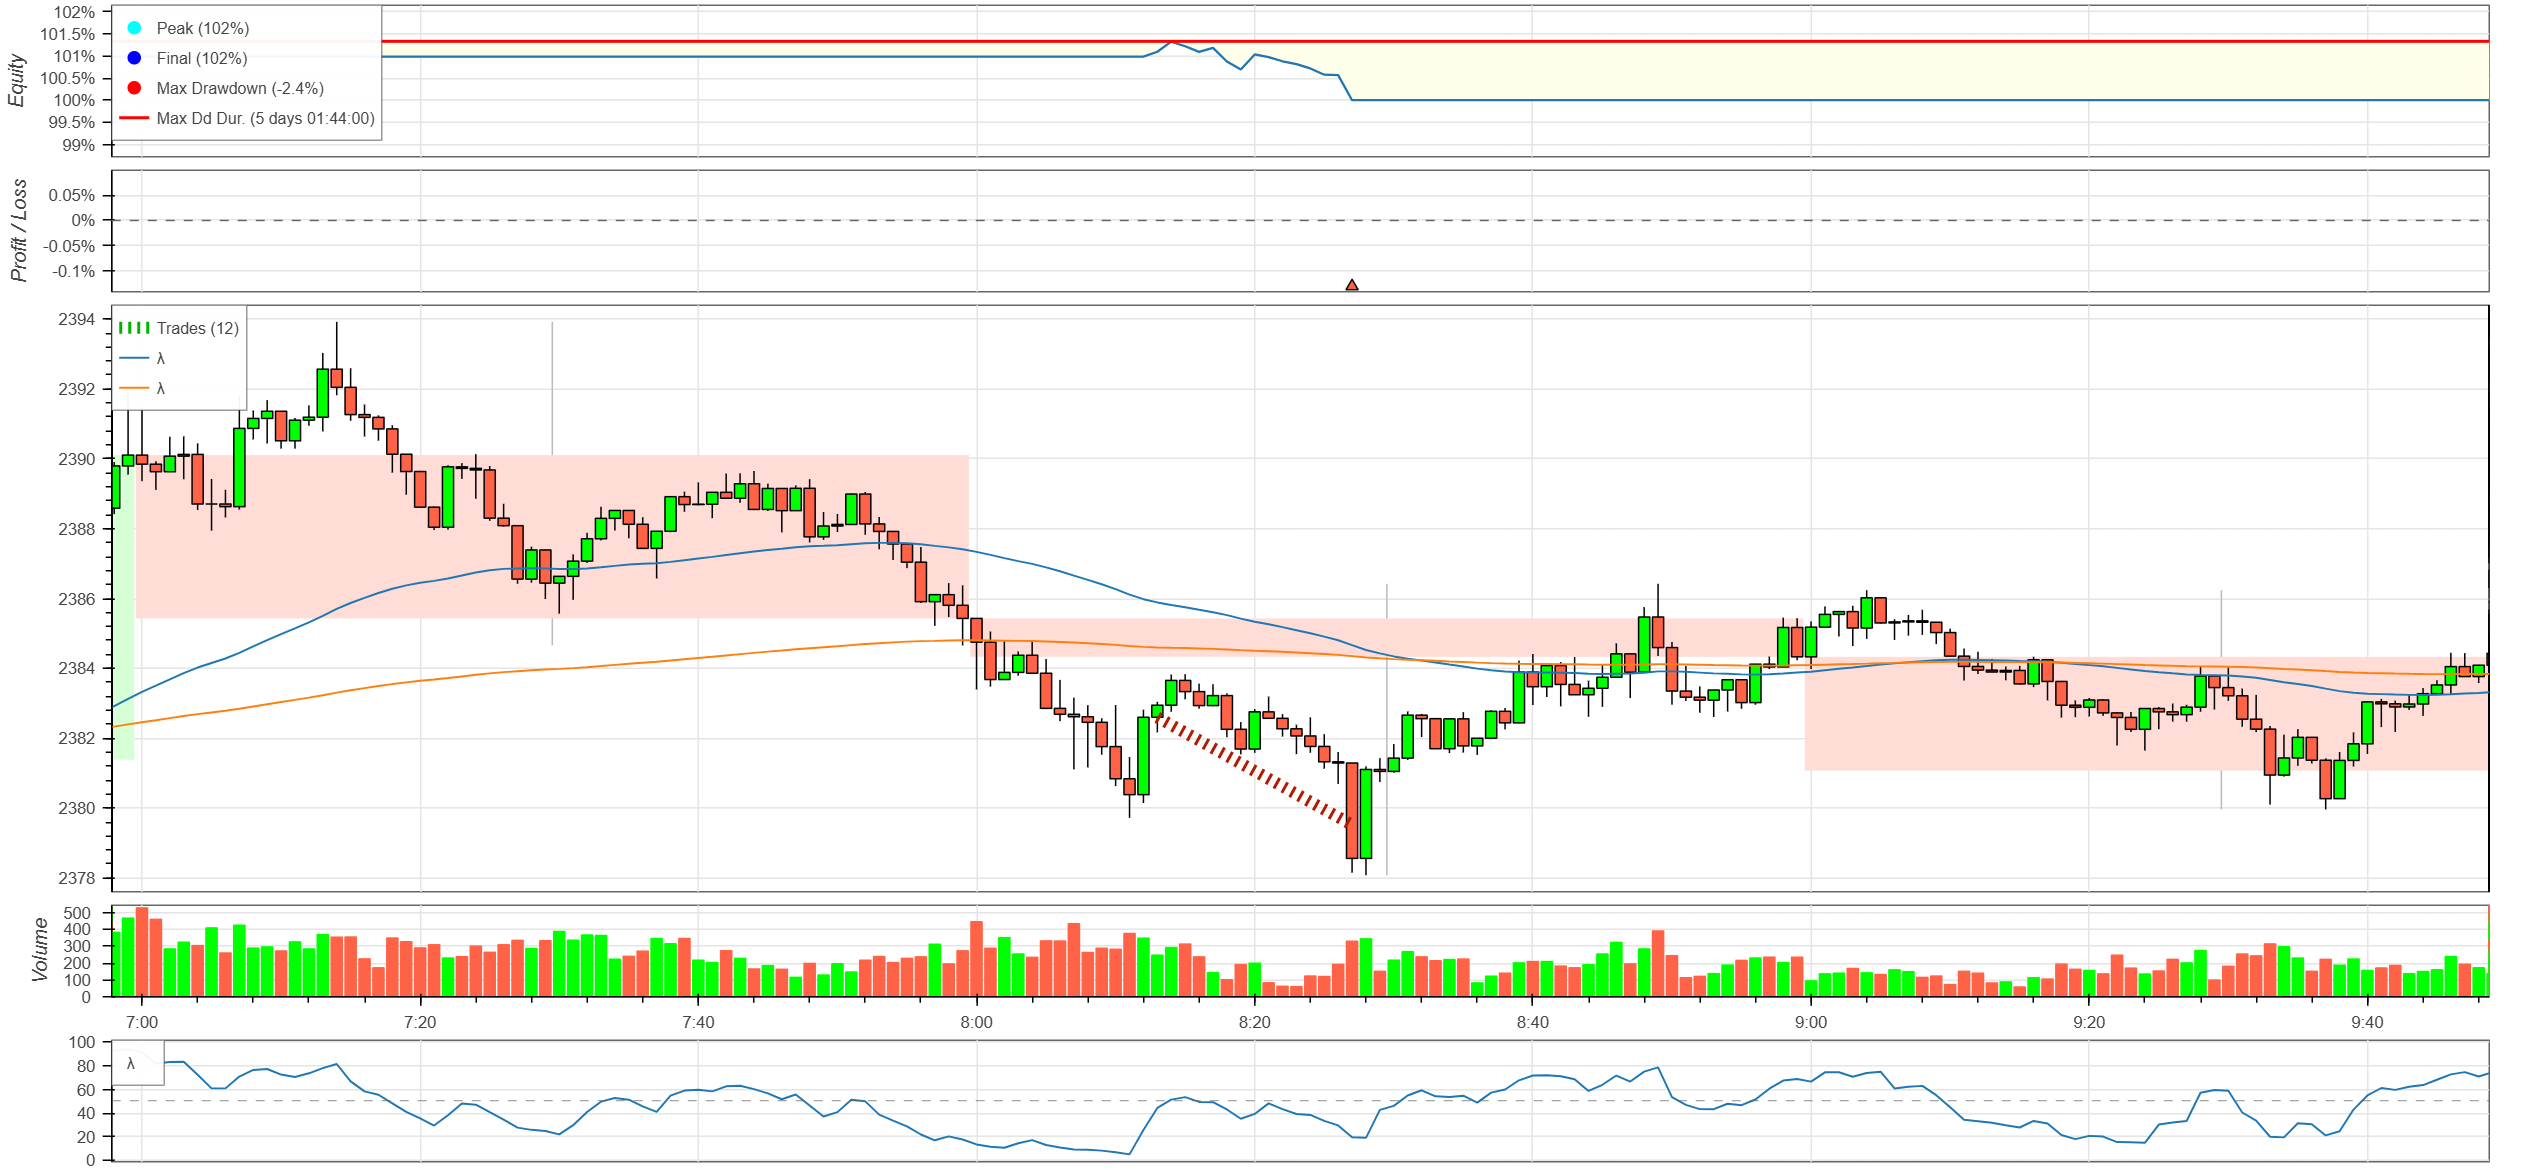

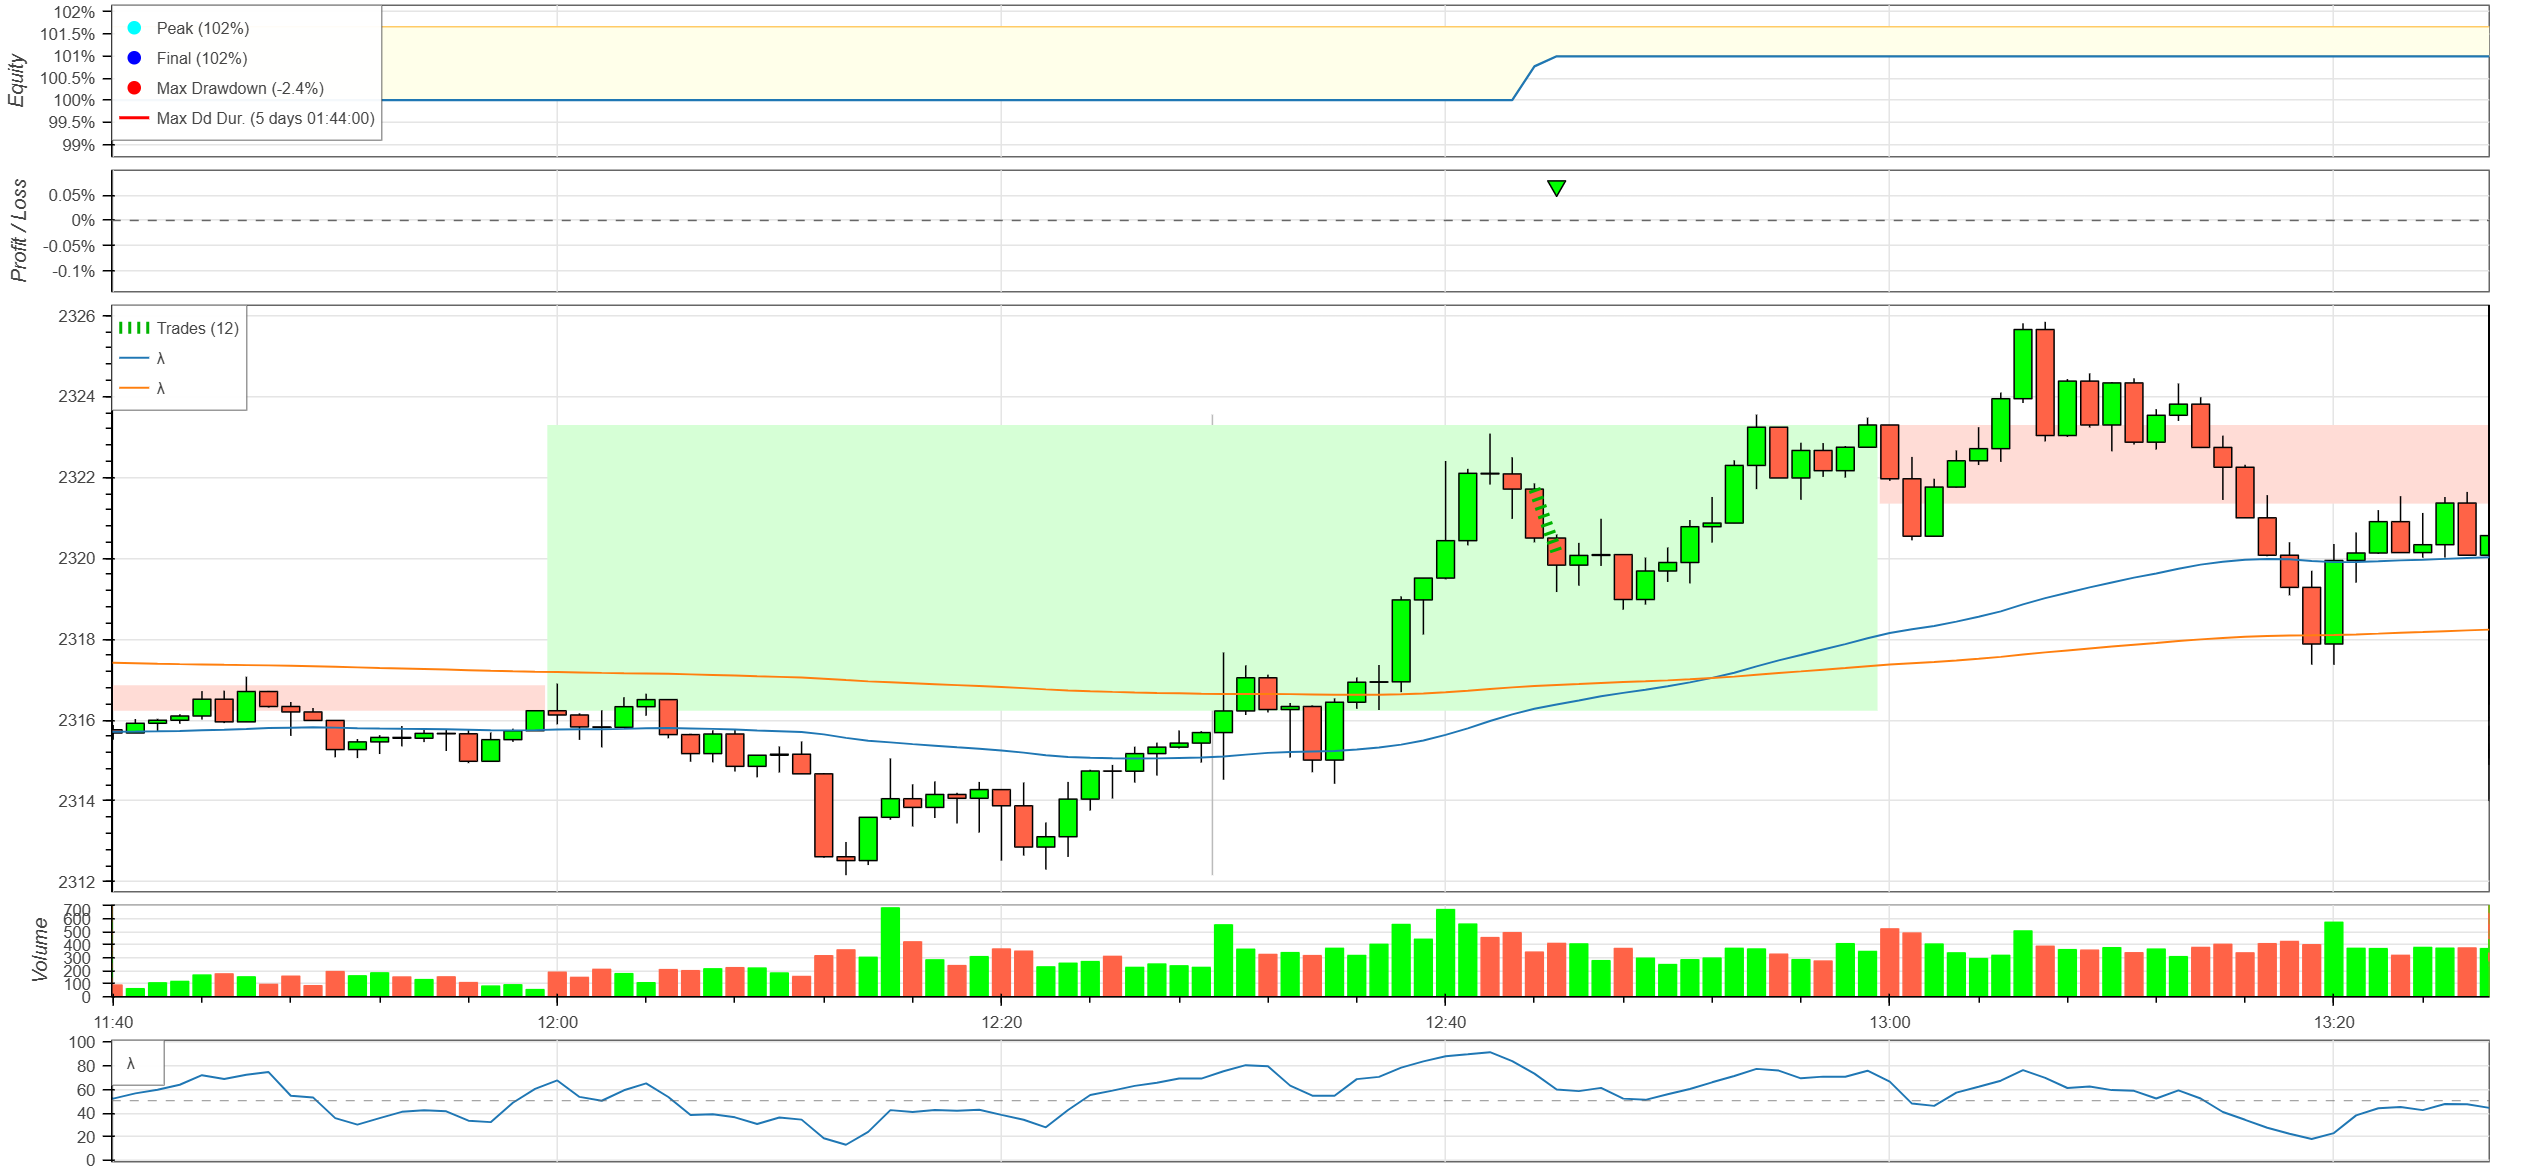

In [5]:
import warnings
import matplotlib.pyplot as plt
from IPython.display import display

# Ignorar todas las advertencias relacionadas con Bokeh y otras DeprecationWarnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Filtrar las últimas 5000 velas del dataframe
filtered_data = dataf_entrenamiento.tail(5000)

# Ejecutar el backtest con los datos filtrados
bt_limited_entrenamiento = Backtest(filtered_data, EMARSIWithPipMarginStrategyCombined, cash=10000, margin=1/10000, commission=.000)
stats_limited_entrenamiento = bt_limited_entrenamiento.run()

# Graficar el backtest con las últimas 5000 velas
bt_limited_entrenamiento.plot()

from IPython.display import Image, display

# Largo

img1 = Image(filename=r"C:\Users\Roger Saavedra\Downloads\bokeh_plot2.png")

# Corto
img2 = Image(filename=r"C:\Users\Roger Saavedra\Downloads\bokeh_plot3.png")

# 
display(img1, img2)



In [6]:
trades_entrenamiento = stats_entrenamiento['_trades']
trades_entrenamiento

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,76,80,84,1929.185,1930.487,98.952,0.000675,2021-01-04 10:30:00,2021-01-04 10:34:00,0 days 00:04:00
1,135,221,222,1930.788,1931.526,99.630,0.000382,2021-01-04 12:51:00,2021-01-04 12:52:00,0 days 00:01:00
2,94,365,366,1933.622,1932.564,-99.452,-0.000547,2021-01-04 15:15:00,2021-01-04 15:16:00,0 days 00:01:00
3,21,370,389,1933.883,1938.550,98.007,0.002413,2021-01-04 15:20:00,2021-01-04 15:39:00,0 days 00:19:00
4,70,1465,1480,1951.007,1949.586,-99.470,-0.000728,2021-01-06 11:35:00,2021-01-06 11:50:00,0 days 00:15:00
...,...,...,...,...,...,...,...,...,...,...
1453,-40,562264,562279,2306.560,2309.035,-99.000,-0.001073,2024-04-23 12:10:00,2024-04-23 12:25:00,0 days 00:15:00
1454,-63,562958,562959,2321.710,2320.140,98.910,0.000676,2024-04-24 12:44:00,2024-04-24 12:45:00,0 days 00:01:00
1455,49,563157,563190,2316.400,2318.435,99.715,0.000879,2024-04-25 05:03:00,2024-04-25 05:36:00,0 days 00:33:00
1456,127,563593,563594,2326.290,2325.505,-99.695,-0.000337,2024-04-25 12:19:00,2024-04-25 12:20:00,0 days 00:01:00


In [7]:
trades_prueba = stats_prueba['_trades']
trades_prueba

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,97,156,159,2339.165,2338.140,-99.425,-0.000438,2024-04-29 11:46:00,2024-04-29 11:49:00,0 days 00:03:00
1,68,168,184,2336.715,2335.250,-99.620,-0.000627,2024-04-29 11:58:00,2024-04-29 12:14:00,0 days 00:16:00
2,-56,935,936,2310.045,2311.805,-98.560,-0.000762,2024-04-30 13:45:00,2024-04-30 13:46:00,0 days 00:01:00
3,-77,1323,1329,2288.340,2287.050,99.330,0.000564,2024-05-01 09:13:00,2024-05-01 09:19:00,0 days 00:06:00
4,-109,1366,1367,2291.820,2292.735,-99.735,-0.000399,2024-05-01 09:56:00,2024-05-01 09:57:00,0 days 00:01:00
...,...,...,...,...,...,...,...,...,...,...
170,100,69151,69151,2618.545,2619.610,106.500,0.000407,2024-09-23 07:23:00,2024-09-23 07:23:00,0 days 00:00:00
171,-217,69305,69308,2621.745,2621.295,97.650,0.000172,2024-09-23 09:57:00,2024-09-23 10:00:00,0 days 00:03:00
172,42,69716,69724,2631.705,2629.420,-95.970,-0.000868,2024-09-24 05:48:00,2024-09-24 05:56:00,0 days 00:08:00
173,28,69730,69827,2627.765,2624.400,-94.220,-0.001281,2024-09-24 06:02:00,2024-09-24 07:39:00,0 days 01:37:00


## 3. Análisis del Backtest

Además de la información generada por `backtesting.py`, añadí dos funciones clave para mejorar el análisis:

- **Racha de operaciones consecutivas**: Muestra el número máximo de operaciones ganadoras y perdedoras consecutivas, lo cual es esencial para la gestión de riesgos.
  
- **Gráfico de equity y drawdown**: Genera gráficos de la curva de equity y drawdown, ofreciendo una visión clara del rendimiento de la estrategia a lo largo del tiempo.

Estas herramientas adicionales permiten evaluar mejor el comportamiento y la efectividad de la estrategia de trading.


In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Función para imprimir el número máximo de trades consecutivos ganadores y perdedores
def print_consecutive_trades(trades):
    """
    Calcula e imprime el número máximo de trades consecutivos ganadores y perdedores.

    Parámetros:
    - trades: DataFrame con la columna 'PnL' que representa las ganancias/perdidas por trade.
    """
    # Determinar si cada trade es ganador o perdedor
    trades['is_winner'] = trades['PnL'] > 0

    # Identificar los cambios entre ganadores y perdedores para formar grupos
    trades['change'] = trades['is_winner'].ne(trades['is_winner'].shift()).cumsum()

    # Calcular la longitud de cada grupo de trades ganadores o perdedores consecutivos
    trades_grouped = trades.groupby(['change', 'is_winner']).size()

    # Obtener el número máximo de trades ganadores y perdedores consecutivos
    max_win_streak = trades_grouped[trades_grouped.index.get_level_values('is_winner')].max()
    max_loss_streak = trades_grouped[~trades_grouped.index.get_level_values('is_winner')].max()

    # Limpiar las columnas temporales
    trades.drop(columns=['is_winner', 'change'], inplace=True)

    print(f"Máximo de trades ganadores consecutivos: {max_win_streak}")
    print(f"Máximo de trades perdedores consecutivos: {max_loss_streak}")

# Función para graficar la curva de equity y drawdown
def plot_equity_and_drawdown(stats, title='Equity y Drawdown'):
    """
    Genera gráficos de la curva de equity y del drawdown basado en los resultados del backtest.

    Parámetros:
    - stats: resultados del backtest (stats_entrenamiento o stats_prueba).
    - title: título opcional para el gráfico.
    """
    # Obtener la curva de equity desde los resultados del backtest
    equity_curve = stats['_equity_curve']
    equity = equity_curve['Equity']

    # Calcular el valor máximo acumulado en cada punto (curva de equity máxima)
    max_equity = equity.cummax()

    # Calcular el drawdown en porcentaje
    drawdown = (equity - max_equity) / max_equity

    # Crear gráficos: equity y drawdown
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})

    # Gráfico de la curva de equity
    ax1.plot(equity.index, equity, label='Curva de Equity', color='blue')
    ax1.set_title(f'Curva de {title}')
    ax1.set_ylabel('Equity')
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.legend()

    # Gráfico del drawdown en porcentaje
    ax2.plot(equity.index, drawdown, label='Drawdown', color='red')
    ax2.fill_between(equity.index, 0, drawdown, where=(drawdown < 0), color='red', alpha=0.3)
    ax2.set_title('Curva de Drawdown')
    ax2.set_ylabel('Drawdown (%)')
    ax2.set_xlabel('Time')
    ax2.grid(True, linestyle='--', alpha=0.5)

    # Ajustar los ticks del eje X para mostrar etiquetas más específicas si es necesario
    ax2.xaxis.set_major_locator(ticker.MaxNLocator(10))  # Ajusta a la cantidad deseada de ticks

    plt.tight_layout()
    plt.show()


Datos de Entrenamiento:
Máximo de trades ganadores consecutivos: 11
Máximo de trades perdedores consecutivos: 14


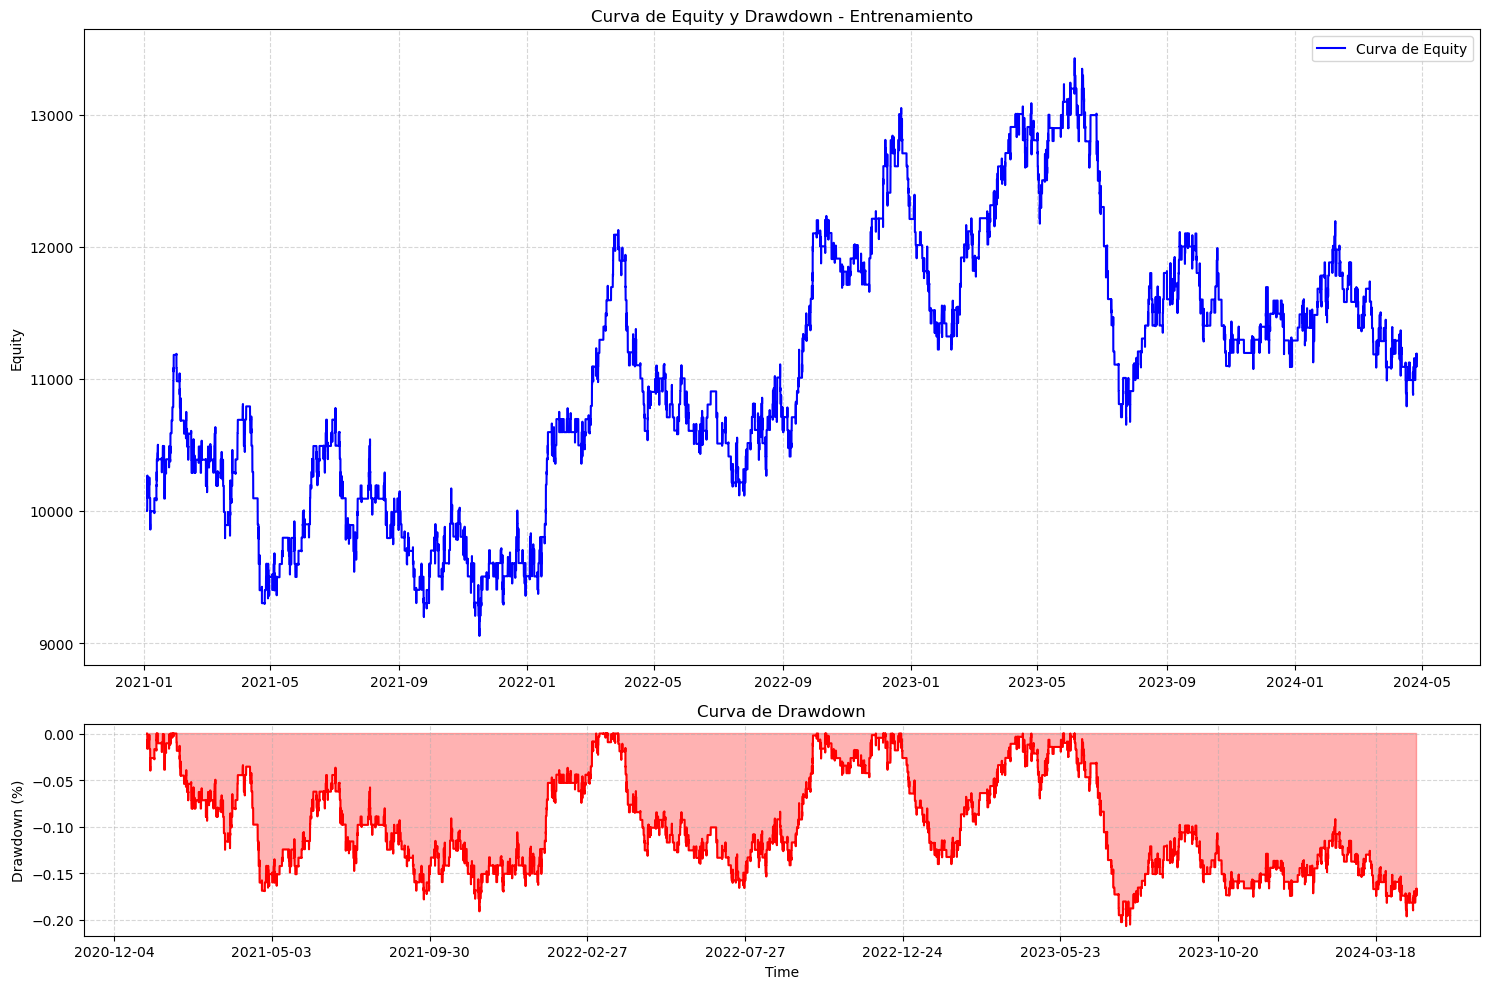


Datos de Prueba:
Máximo de trades ganadores consecutivos: 7
Máximo de trades perdedores consecutivos: 9


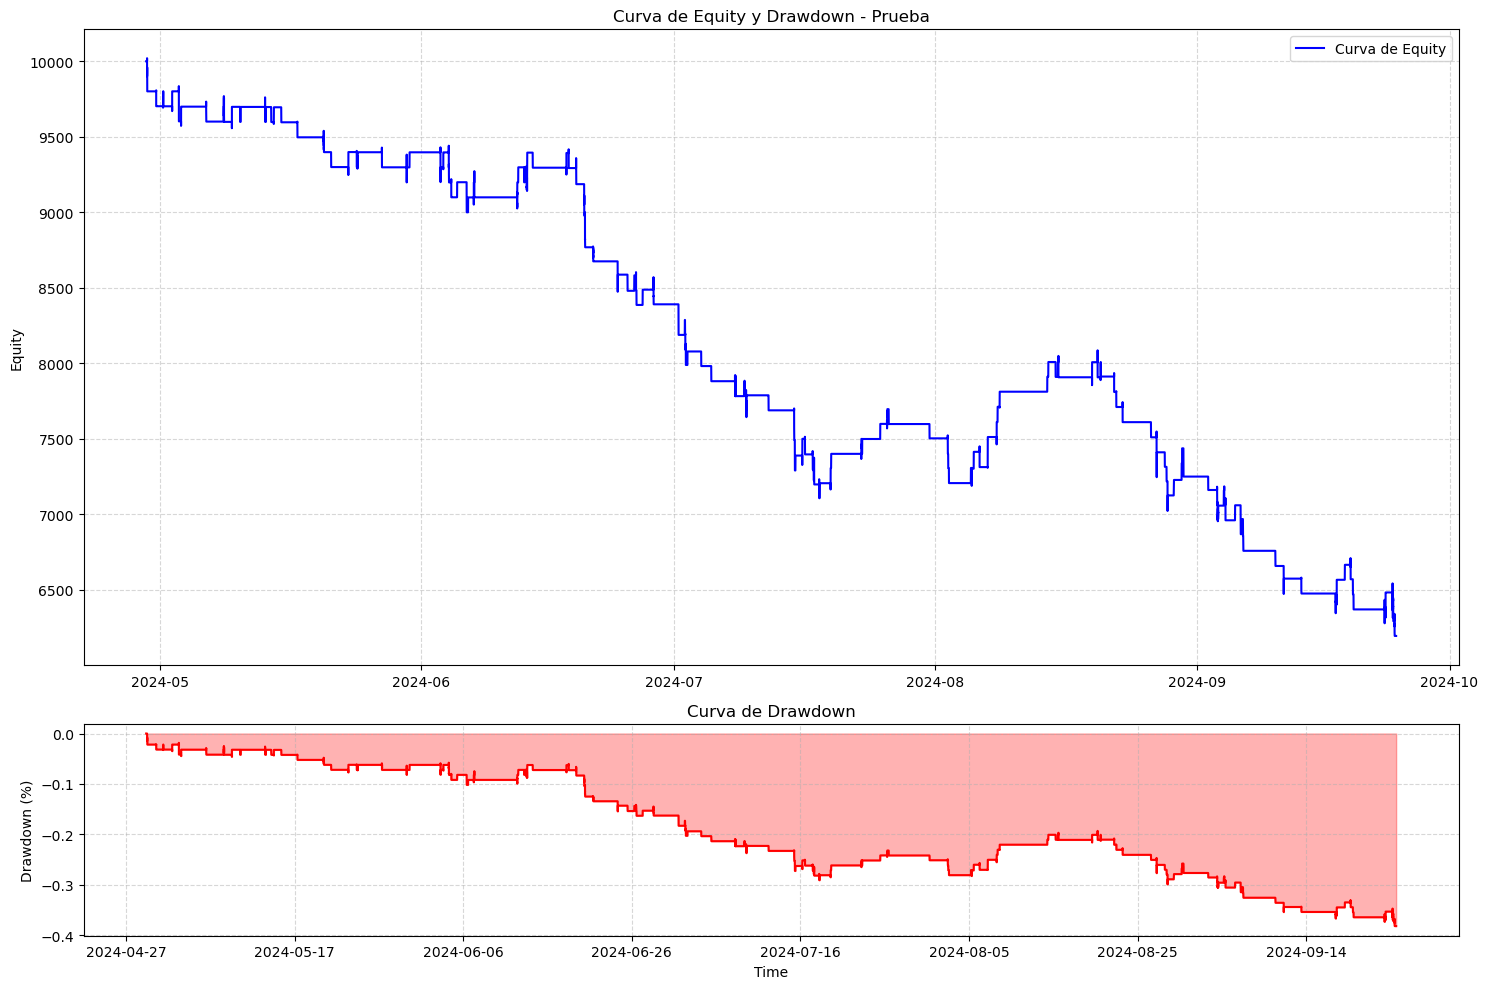

In [9]:
# Para los datos de entrenamiento
print("Datos de Entrenamiento:")
print_consecutive_trades(trades_entrenamiento)
plot_equity_and_drawdown(stats_entrenamiento, title='Equity y Drawdown - Entrenamiento')

# Para los datos de prueba
print("\nDatos de Prueba:")
print_consecutive_trades(trades_prueba)
plot_equity_and_drawdown(stats_prueba, title='Equity y Drawdown - Prueba')


## Conclusiones

### Número promedio de operaciones diarias:
La estrategia genera aproximadamente **1.2 operaciones diarias**. Aunque es una cifra moderada para una estrategia basada en velas de 1 minuto, proporciona una cantidad suficiente de operaciones para evaluar la efectividad del sistema sin sobreexponer al trader.

### Win Rate [%]: 50.41%
Con una tasa de aciertos apenas superior al **50%** y un ratio riesgo/beneficio de 1:1, la estrategia se muestra marginalmente rentable. Sin embargo, dado que el backtest se realizó **sin considerar comisiones**, es probable que los costos asociados a las operaciones hagan que la estrategia sea menos rentable o incluso perdedora en escenarios reales.

### Return [%]: 11.90%
El retorno total obtenido del **11.90%** durante el periodo de prueba es significativamente inferior al retorno del **Buy & Hold** del mismo activo, lo que indica que la estrategia no maximiza las oportunidades de ganancia en comparación con una estrategia pasiva a largo plazo.

### Max. Drawdown [%]: -20.67%
Un drawdown máximo del **20.67%** es elevado, especialmente considerando que la estrategia arriesga solo un **1% del capital** por operación. Este nivel de drawdown puede ser difícil de gestionar para algunos traders, ya que implica una recuperación prolongada y un riesgo elevado de pérdida.

### Rachas de operaciones:

- **Máximo de trades ganadores consecutivos**: 11  
- **Máximo de trades perdedores consecutivos**: 14  

La racha de operaciones perdedoras es más prolongada que la de ganadoras, lo que podría afectar la confianza del trader y exigir un mayor control emocional. Perder **14 operaciones seguidas** podría llevar a una crisis de confianza en la estrategia si no se cuenta con un plan de gestión del riesgo adecuado.

### Duración promedio de las operaciones:
Las operaciones duran, en promedio, **9 minutos**, lo que permite un ritmo relativamente rápido de entradas y salidas, adecuado para traders intradía que buscan capturar movimientos rápidos del mercado.

---

## Validación de Datos

### Integridad y consistencia de los datos
Se graficaron las últimas **5000 velas** para validar visualmente que la estrategia sigue correctamente las reglas predefinidas. Los datos no presentan anomalías ni inconsistencias en su ejecución, lo que confirma la fiabilidad de los resultados obtenidos en el backtest.

### Comparación con TradingView
La estrategia fue replicada en **TradingView** para validar los resultados del backtest, asegurando que las señales de entrada y salida sean consistentes con la lógica implementada. Esta doble validación es fundamental para garantizar la precisión del análisis y confirmar que la estrategia se comporta de manera coherente en diferentes plataformas.

---

## Conclusiones Generales

### Rentabilidad estadística:
Aunque la estrategia ha demostrado ser estadísticamente rentable, con un retorno positivo y un win rate apenas superior al 50%, los resultados actuales no alcanzan su máximo potencial. Existe un margen considerable para optimizar el sistema, especialmente en aspectos clave como la gestión del riesgo y la reducción del drawdown. Además, es importante tener en cuenta que durante el periodo de prueba, la estrategia resultó en pérdidas netas.

### Próximos pasos:
El siguiente paso será **optimizar la estrategia utilizando algoritmos de Machine Learning** para mejorar la toma de decisiones en las operaciones y ajustar las reglas de entrada y salida con base en patrones más avanzados. Esto podría potenciar la rentabilidad y reducir la exposición al riesgo.
